# Introduction to Regularization for Deep Neural Nets

## Stephen Elston
## Machine Learning 410

This lesson will introduce you to the principles of regularization required to successfully train deep neural networks. In this lesson you will:

1. Understand the need for regularization of complex machine learning models, particularly deep NNs. 
2. Know how to apply constriant-based regularization using the L1 and L2 norms.
3. Understand and apply the concept of data augmentation. 
4. Know how to apply dropout regularization. 
5. Understand and apply early stopping. 
6. Understand the advantages of various regulariztion methods and know when how to apply them in combination. 

## 1.0 Why do we need regularization for deep learning?

Deep learning models have a great number parameters (weights) which must be fit. This situation arrises form the wide and deep architectures that are required to achieve significant **model capacity** to represent complex functions. 

These large number of parameters mean that deep learning models are typically over-fit. Therefore, regularization methods are pervasively used to prevent over-fitting.

### 2.1 Demonstration of over-parameterizaton

Let's try a simple example. We will construct a regression models with different numbers of paramters and therefore different model capacities. 

As a first step, we will create a simple single regression model of some synthetic data. The code in the cell below creates some data computed from a straight line but with considerable Normally distributed random noise. A plot is then created of the result. Exectue this code and examine the reuslting plot.  

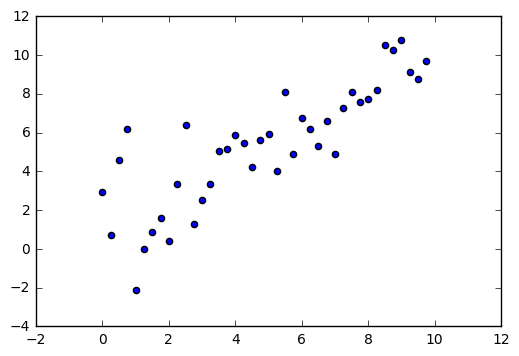

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, seed
seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.25) 
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)

Notice that the data fall approximately on a straight line, but with significant deviations. 

Next, we will compute a simple single regression model. This model has an intercept term and a single parameter. The code in the cell below splits the data into randomly selected training and testing subsets. Execute this code.

In [32]:
import sklearn.model_selection as ms
indx = range(len(x))
seed(9988)
indx = ms.train_test_split(indx, test_size = 20)
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

Next, we will use the linear model in 'sklearn.linear_model' package to create a single regression model for these data. The code in the cell below does just this, prints the single model coefficient and plots the result. Execute this code. 

***
**Note:** you can find documentation along with some examples of scikit-learn regression models on the [regression models pages](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
***

[ 2.18028763]


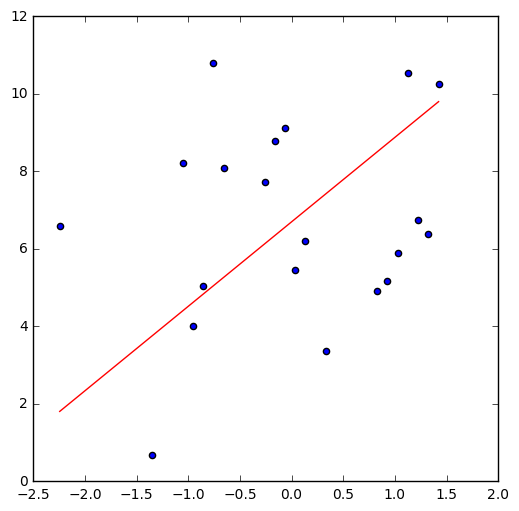

In [33]:
import sklearn.linear_model as slm
from sklearn.preprocessing import scale

def plot_reg(x, y_score, y):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    
    ## Get the data in plot order
    xy = sorted(zip(x,y_score))
    x = [x for x, _ in xy]
    y_score = [y for _, y in xy]

    ## Plot the result
    plt.plot(x, y_score, c = 'red')
    plt.scatter(x, y)

def reg_model(x, y):
    mod = slm.LinearRegression()
    x_scale = scale(x)  # .reshape(-1, 1)
    mod.fit(x_scale, y)
    print(mod.coef_)
    return mod, x_scale, mod.predict(x_scale)

mod, x_scale, y_hat = reg_model(x_train.reshape(-1, 1), y_train)

plot_reg(x_scale, y_hat, y_train)

Examine these results. Notice that the single coefficient (slope) seems reasonable. Visually, the fit to the data looks reasonable. 

We should also test the fit to some test data. The code in the cell does just this and returns the RMS error. execute this code.

1.9292639905624642

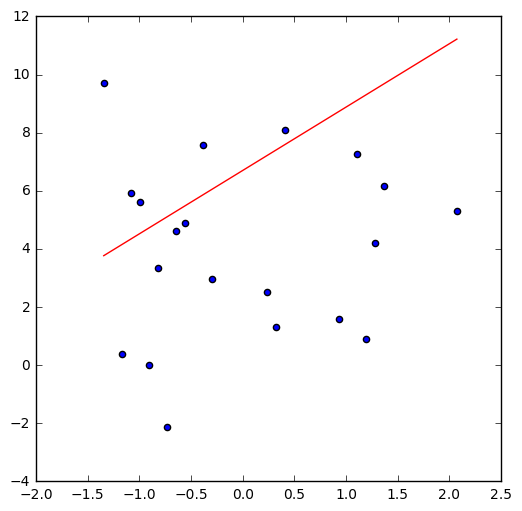

In [34]:
from math import sqrt
def test_mod(x,y, mod):
    x_scale = scale(x)
    y_score = mod.predict(x_scale)
    plot_reg(x_scale, y_score, y)
    return np.std(y_score - y)

test_mod(x_test.reshape(-1, 1), y_test, mod)

Again, these results look reasonable. The RMSE is also reasonable given the significant dispursion in these data. 

Now, let's try a model with significantly higher capacity. In this case we compute new features for a 9th order polynimial model. Using this new set of features a new regression model is trained and a summary displayed. 

[    3801.79377136   -55910.91606409   340393.61247268 -1135034.00400079
  2291726.97982466 -2884767.48254261  2217807.98161658  -954167.45871625
   176179.90379154]
0.732968169553


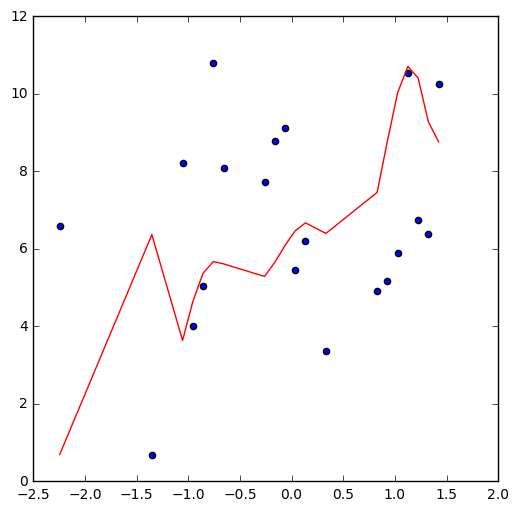

In [35]:
seed(2233)
x_power = np.power(x_train.reshape(-1, 1), range(1,10))
x_scale = scale(x_power)

mod_power = slm.LinearRegression()
mod_power.fit(x_scale, y_train)
y_hat_power = mod_power.predict(x_scale)

plot_reg(x_scale[:,0], y_hat_power, y_train)

print(mod_power.coef_)
print(np.std(y_hat_power - y_train))

Notice the following, indicating the the model is quite over-fit. 
- The coefficient values are over a wide range ($10^7$). This in contrast to the coefficient of the single regression model which had a reasonable single digit value.
- The graph of the fitted model shows highly complex behavior. 

Now, we will try to test the model with the held-back test data. The code in the cell below creates the same features and applies the `predict` method to the model using these test features. 

1005937.91312


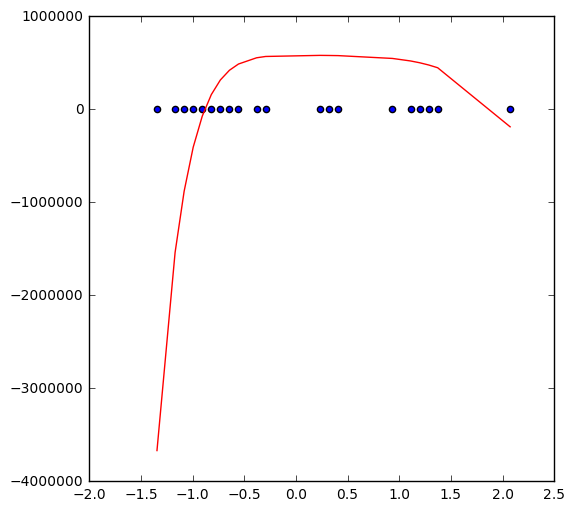

In [36]:
x_test_scale = scale(x_test.reshape(-1, 1)) # Prescale to prevent numerical overflow. 
x_test_power = np.power(x_test_scale, range(1,10))
x_scale_test = scale(x_test_power)

y_hat_power = mod_power.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_power, y_test)

print(np.std(y_hat_power - y_test))

This is clearly a terible fit! The RMSE is enrourmous and the curve of predicted values bears little resemblence to the test values. Indeed, this is a common problem with over-fit models that the errors grow in very rapidly toward the edges of the training data domain.

## 2.0 L2 regularization

We will now explore one of the mostly widely used regularization methods, offen referred to as L2 regularization. 

The same method goes by some other names, as it seems to have been 'invented' several times. In particular the method is known as, **Tikhonov regularization**, **L2 norm regularization**, **pre-whitening** in engineering, and for linear models **ridge regression**. In all likelihood the method was first developted by the Russian mathematician Andrey Tikhonov in the late 1940's. His work was not widely known in the west since his short book on the subject was only first published in english in 1977.

![](img/Tikhonov_board.jpg)
<center> **Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**


So, what is the basic idea? L2 regulariztion applies a **penelty** proportional to the **L2** or **eucldian norm** of the model weights to the loss function. The total loss function then can be written as follows:  

$$J(\theta) = J_{MLE}(\theta) + \lambda ||\theta||^2$$

Where,

$$||\theta||^2 = \Big( \sum_{i=1}^n W_i^2 \Big)^{\frac{1}{2}}$$

Is the l2

You can think of penelty as limiting the L2 or Euclidean norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L2.jpg)
<center> **Geometric view of L2 regularization**



## 2.1 The eigenvalue penalty interpretation

Let's start by examining the **normal equation** formulation of the linear regresson problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used Normal Equation form can help:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is an $m x m$ matrix, and thus is of reduced dimension. But, **$A^TA$ can still be rank deficient!** 

The basic idea of ridge regression is to stabalize the inverse sigular value matrix,$D^+$, by **adding a small bias term**, $\lambda$, to each of the singular values. We can state this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \lambda \cdot b\parallel]\\  or \\
b = (A^TA + \lambda^2)^{-1}A^Tx$$

In this way, the values of small signular values do not blow up when we compute the inverse. You can see this by writing out the $D^+$ matrix with the bias term.

$$D_{ridge}^+  = \begin{bmatrix}
    \frac{1}{d_1 + \lambda^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{d_2 + \lambda^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{d_m + \lambda^2}
\end{bmatrix}$$

Adding this bias term creates a 'ridge' in the singular value matrix, giving this method its name **ridge regression**. 


Let's give this a try. Execute the code in the cell below which computes the $(A^TA + \lambda^2)^{-1}A^T$ matrix with a lambda value of `0.1`.

1.22405924382
[ 1.35924056  0.30472335  0.21513283  0.2553236   0.25085494  0.17711915
  0.04339031 -0.13528087 -0.34506222]


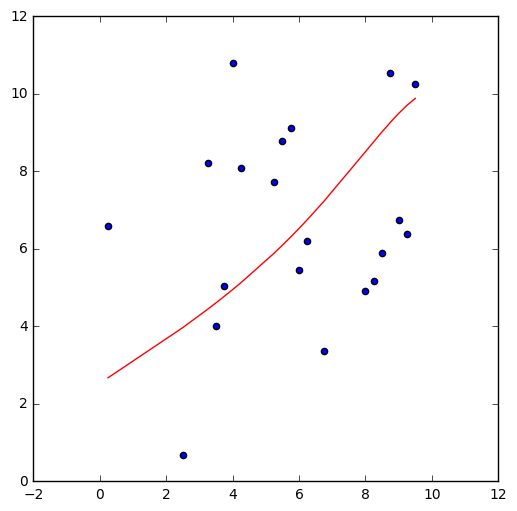

In [37]:
mod_L2 = slm.Ridge(alpha = 1.0)
mod_L2.fit(x_scale, y_train)
y_hat_L2 = mod_L2.predict(x_scale)

print(np.std(y_hat_L2 - y_train))
print(mod_L2.coef_)

plot_reg(x_train, y_hat_L2, y_train)

1.9160891445


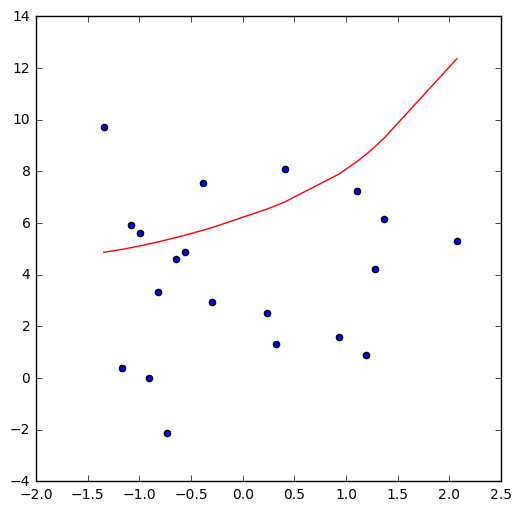

In [38]:
y_hat_L2 = mod_L2.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L2, y_test)

print(np.std(y_hat_L2 - y_test))

### Lasso regression

We can also do regularization using other norms. **Lasso or L1 regularizaton** limits the sum of the absolute values of the model coefients. The L1 norm is sometime know as the **Manhattan norm**, since distrance are measured as if you were traveling on a rectangular grid of streets. 

You can also think of lasso regression as limiting the L1 norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L1.jpg)
<center> **Geometric view of L1 regularization**

By setting the `alpha` argument to `glmnet` to zero you can perform lasso regresson. Execute the code in the cell below to compute and evaluate a lasso regression model with 20 values of lambda.

3.00451604918
[ 1.85254516  0.          0.          0.12691421  0.01566206  0.          0.
  0.          0.        ]


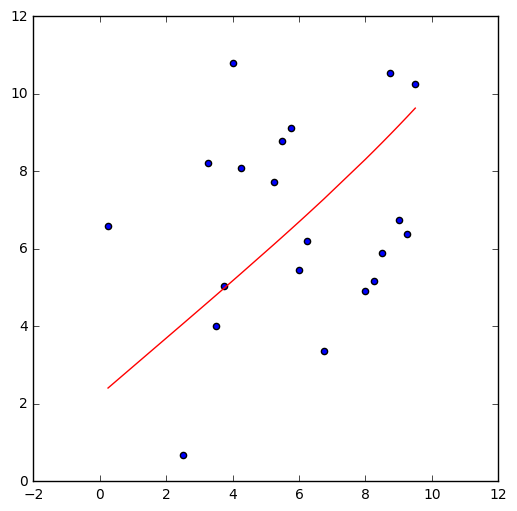

In [39]:
mod_L1 = slm.Lasso(alpha = 0.2, max_iter=100000)
mod_L1.fit(x_scale, y_train)
y_hat_L1 = mod_L1.predict(x_scale)

print(np.std(y_hat_L1 - y_test))
print(mod_L1.coef_)

plot_reg(x_train, y_hat_L1, y_train)

1.93671281307


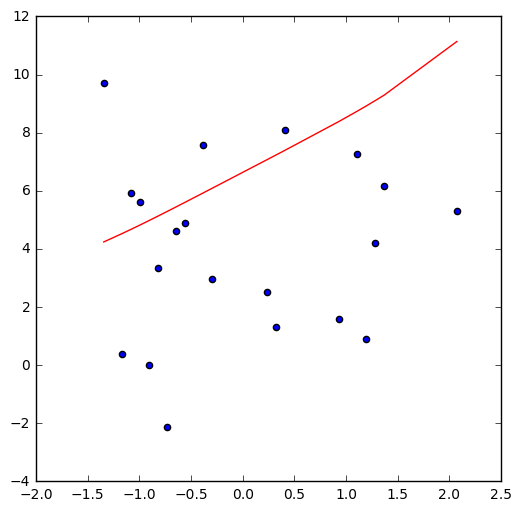

In [40]:
y_hat_L1 = mod_L1.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L1, y_test)

print(np.std(y_hat_L1 - y_test))

#### Copyright 2018 Stephen F Elston. All rights reserved.